# The Annotated Encoder-Decoder with Attention

Recently, Alexander Rush wrote a blog post called [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html), describing the Transformer model from the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). This post can be seen as a **prequel** to that: *we will implement an Encoder-Decoder with Attention* using (Gated) Recurrent Neural Networks, very closely following the original attention-based neural machine translation paper ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473) of Bahdanau et al. (2015). 

The idea is that going through both blog posts will make you familiar with two very influential sequence-to-sequence architectures. If you have any comments or suggestions, please let me know: [@bastings_nlp](https://twitter.com/bastings_nlp).

# Model Architecture

We will model the probability $p(Y\mid X)$ of a target sequence $Y=(y_1, \dots, y_{N})$ given a source sequence $X=(x_1, \dots, x_M)$ directly with a neural network: an Encoder-Decoder.

<img src="https://github.com/bastings/annotated_encoder_decoder/blob/master/images/bahdanau.png?raw=1" width="636">

#### Encoder 

The encoder reads in the source sentence (*at the bottom of the figure*) and produces a sequence of hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$, one for each source word. These states should capture the meaning of a word in its context of the given sentence.

We will use a bi-directional recurrent neural network (Bi-RNN) as the encoder; a Bi-GRU in particular.

First of all we **embed** the source words. 
We simply look up the **word embedding** for each word in a (randomly initialized) lookup table.
We will denote the word embedding for word $i$ in a given sentence with $\mathbf{x}_i$.
By embedding words, our model may exploit the fact that certain words (e.g. *cat* and *dog*) are semantically similar, and can be processed in a similar way.

Now, how do we get hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$? A forward GRU reads the source sentence left-to-right, while a backward GRU reads it right-to-left.
Each of them follows a simple recursive formula: 
$$\mathbf{h}_j = \text{GRU}( \mathbf{x}_j , \mathbf{h}_{j - 1} )$$
i.e. we obtain the next state from the previous state and the current input word embedding.

The hidden state of the forward GRU at time step $j$ will know what words **precede** the word at that time step, but it doesn't know what words will follow. In contrast, the backward GRU will only know what words **follow** the word at time step $j$. By **concatenating** those two hidden states (*shown in blue in the figure*), we get $\mathbf{h}_j$, which captures word $j$ in its full sentence context.


#### Decoder 

The decoder (*at the top of the figure*) is a GRU with hidden state $\mathbf{s_i}$. It follows a similar formula to the encoder, but takes one extra input $\mathbf{c}_{i}$ (*shown in yellow*).

$$\mathbf{s}_{i} = f( \mathbf{s}_{i - 1}, \mathbf{y}_{i - 1}, \mathbf{c}_i )$$

Here, $\mathbf{y}_{i - 1}$ is the previously generated target word (*not shown*).

At each time step, an **attention mechanism** dynamically selects that part of the source sentence that is most relevant for predicting the current target word. It does so by comparing the last decoder state with each source hidden state. The result is a context vector $\mathbf{c_i}$ (*shown in yellow*).
Later the attention mechanism is explained in more detail.

After computing the decoder state $\mathbf{s}_i$, a non-linear function $g$ (which applies a [softmax](https://en.wikipedia.org/wiki/Softmax_function)) gives us the probability of the target word $y_i$ for this time step:

$$ p(y_i \mid y_{<i}, x_1^M) = g(\mathbf{s}_i, \mathbf{c}_i, \mathbf{y}_{i - 1})$$

Because $g$ applies a softmax, it provides a vector the size of the output vocabulary that sums to 1.0: it is a distribution over all target words. During test time, we would select the word with the highest probability for our translation.

Now, for optimization, a [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) is used to maximize the probability of selecting the correct word at this time step. All parameters (including word embeddings) are then updated to maximize this probability.



# Prelims

This tutorial requires **PyTorch >= 0.4.1** and was tested with **Python 3.6**.  

Make sure you have those versions, and install the packages below if you don't have them yet.

In [26]:
!pip install torch numpy matplotlib sacrebleu

     |████████████████████████████████| 71kB 6.2MB/s 


In [3]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


# Let's start coding!

## Model class

Our base model class `EncoderDecoder` is very similar to the one in *The Annotated Transformer*.

One difference is that our encoder also returns its final states (`encoder_final` below), which is used to initialize the decoder RNN. We also provide the sequence lengths as the RNNs require those.

In [4]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

To keep things easy we also keep the `Generator` class the same. 
It simply projects the pre-output layer ($x$ in the `forward` function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [5]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder

Our encoder is a bi-directional GRU. 

Because we want to process multiple sentences at the same time for speed reasons (it is more effcient on GPU), we need to support **mini-batches**. Sentences in a mini-batch may have different lengths, which means that the RNN needs to unroll further for certain sentences while it might already have finished for others:

```
Example: mini-batch with 3 source sentences of different lengths (7, 5, and 3).
End-of-sequence is marked with a "3" here, and padding positions with "1".

+---------------+
| 4 5 9 8 7 8 3 |
+---------------+
| 5 4 8 7 3 1 1 |
+---------------+
| 5 8 3 1 1 1 1 |
+---------------+
```
You can see that, when computing hidden states for this mini-batch, for sentence #2 and #3 we will need to stop updating the hidden state after we have encountered "3". We don't want to incorporate the padding values (1s).

Luckily, PyTorch has convenient helper functions called `pack_padded_sequence` and `pad_packed_sequence`.
These functions take care of masking and padding, so that the resulting word representations are simply zeros after a sentence stops.

The code below reads in a source sentence (a sequence of word embeddings) and produces the hidden states.
It also returns a final vector, a summary of the complete sentence, by concatenating the first and the last hidden states (they have both seen the whole sentence, each in a different direction). We will use the final vector to initialize the decoder.

In [6]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

### Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector. 

#### Training
In `forward` you can find a for-loop that computes the decoder hidden states one time step at a time. 
Note that, during training, we know exactly what the target words should be! (They are in `trg_embed`.) This means that we are not even checking here what the prediction is! We simply feed the correct previous target word embedding to the GRU at each time step. This is called teacher forcing.

The `forward` function returns all decoder hidden states and pre-output vectors. Elsewhere these are used to compute the loss, after which the parameters are updated.

#### Prediction
For prediction time, for forward function is only used for a single time step. After predicting a word from the returned pre-output vector, we can call it again, supplying it the word embedding of the previously predicted word and the last state.

In [7]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))            


### Attention                                                                                                                                                                               

At every time step, the decoder has access to *all* source word representations $\mathbf{h}_1, \dots, \mathbf{h}_M$. 
An attention mechanism allows the model to focus on the currently most relevant part of the source sentence.
The state of the decoder is represented by GRU hidden state $\mathbf{s}_i$.
So if we want to know which source word representation(s) $\mathbf{h}_j$ are most relevant, we will need to define a function that takes those two things as input.

Here we use the MLP-based, additive attention that was used in Bahdanau et al.:

<img src="https://github.com/bastings/annotated_encoder_decoder/blob/master/images/attention.png?raw=1" width="280">


We apply an MLP with tanh-activation to both the current decoder state $\bf s_i$ (the *query*) and each encoder state $\bf h_j$ (the *key*), and then project this to a single value (i.e. a scalar) to get the *attention energy* $e_{ij}$. 

Once all energies are computed, they are normalized by a softmax so that they sum to one: 

$$ \alpha_{ij} = \text{softmax}(\mathbf{e}_i)[j] $$

$$\sum_j \alpha_{ij} = 1.0$$ 

The context vector for time step $i$ is then a weighted sum of the encoder hidden states (the *values*):
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$

In [8]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
We use learned embeddings to convert the input tokens and output tokens to vectors of dimension `emb_size`.

We will simply use PyTorch's [nn.Embedding](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) class.

## Full Model

Here we define a function from hyperparameters to a full model. 

In [9]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

# Training

This section describes the training regime for our models.

We stop for a quick interlude to introduce some of the tools 
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as their lengths and masks. 

## Batches and Masking

In [10]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                

## Training Loop
The code below trains the model for 1 epoch (=1 pass through the training data).

In [11]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

## Training Data and Batching

We will use torch text for batching. This is discussed in more detail below. 

## Optimizer

We will use the [Adam optimizer](https://arxiv.org/abs/1412.6980) with default settings ($\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$).

We will use $0.0003$ as the learning rate here, but for different problems another learning rate may be more appropriate. You will have to tune that.

# A First  Example

We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols. 

## Synthetic Data

In [12]:
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)

## Loss Computation

In [13]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

### Printing examples

To monitor progress during training, we will translate a few examples.

We use greedy decoding for simplicity; that is, at each time step, starting at the first token, we choose the one with that maximum probability, and we never revisit that choice. 

In [14]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [15]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

## Training the copy task

In [16]:
def train_copy_task():
    """Train the simple copy task."""
    num_words = 11
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = make_model(num_words, num_words, emb_size=32, hidden_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=100))
 
    dev_perplexities = []
    
    if USE_CUDA:
        model.cuda()

    for epoch in range(10):
        
        print("Epoch %d" % epoch)

        # train
        model.train()
        data = data_gen(num_words=num_words, batch_size=32, num_batches=100)
        run_epoch(data, model,
                  SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad(): 
            perplexity = run_epoch(eval_data, model,
                                   SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            print_examples(eval_data, model, n=2, max_len=9)
        
    return dev_perplexities

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Epoch Step: 50 Loss: 19.720032 Tokens per Sec: 10584.053888
Epoch Step: 100 Loss: 17.850552 Tokens per Sec: 14007.234747
Evaluation perplexity: 7.165516

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  5 8 7 5 8 7 5 8 7

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 8 8 8 8 8 8 8

Epoch 1
Epoch Step: 50 Loss: 15.429652 Tokens per Sec: 13223.438849
Epoch Step: 100 Loss: 11.758204 Tokens per Sec: 14524.938664
Evaluation perplexity: 3.761093

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 5 3 8 7 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 8 2 5 8 3 2

Epoch 2
Epoch Step: 50 Loss: 9.917423 Tokens per Sec: 14493.763777
Epoch Step: 100 Loss: 8.949948 Tokens per Sec: 13950.354845
Evaluation perplexity: 2.573576

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 3 5 7 8 10

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 

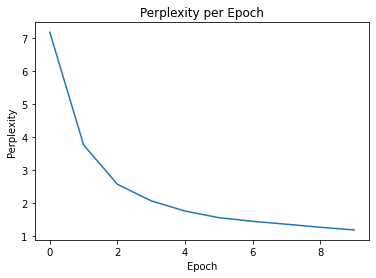

In [17]:
# train the copy task
dev_perplexities = train_copy_task()

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

You can see that the model managed to correctly 'translate' the two examples in the end.

Moreover, the perplexity of the development data nicely went down towards 1.

# A Real World Example

Now we consider a real-world example using the IWSLT German-English Translation task. 
This task is much smaller than usual, but it illustrates the whole system. 

The cell below installs torch text and spacy. This might take a while.

In [18]:
!pip install git+git://github.com/pytorch/text spacy 
!python -m spacy download en
!python -m spacy download de

  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-9o9r23of
  Running command git clone -q git://github.com/pytorch/text /tmp/pip-req-build-9o9r23of
  Running command git submodule update --init --recursive -q
  Created wheel for torchtext: filename=torchtext-0.9.0a0+97e6d1d-cp36-cp36m-linux_x86_64.whl size=6978798 sha256=36ab37847ef7da9301287d4286ad90606b3686a7a48bbfd37601454f8e151ca9
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9ln4_qs/wheels/39/42/ff/82f5ccbb0f30b25e14610376f5d0c67913fc05017dab59f8eb
Successfully built torchtext
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████

## Data Loading

We will load the dataset using torchtext and spacy for tokenization.

This cell might take a while to run the first time, as it will download and tokenize the IWSLT data.

For speed we only include short sentences, and we include a word in the vocabulary only if it occurs at least 5 times. In this case we also lowercase the data.

If you have **issues** with torch text in the cell below (e.g. an `ascii` error), try running `export LC_ALL="en_US.UTF-8"` before you start `jupyter notebook`.

In [19]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]


/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:03<00:00, 6.08MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/train.tags.de-en.en
.data/iwslt/de-en/train.tags.de-en.de


/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


### Let's look at the data

It never hurts to look at your data and some statistics.

In [20]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 143115
valid 690
test 963 

First training example:
src: david gallo : das ist bill lange . ich bin dave gallo .
trg: david gallo : this is bill lange . i 'm dave gallo . 

Most common words (src):
         .     138329
         ,     105944
       und      41843
       die      40808
       das      33324
       sie      33034
       ich      31150
       ist      31037
        es      27449
       wir      25817 

Most common words (trg):
         .     137259
         ,      91615
       the      73343
       and      50276
        to      42799
         a      39572
        of      39496
         i      33521
        it      32920
      that      32640 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 .
04 ,
05 und
06 die
07 das
08 sie
09 ich 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 the
07 and
08 to
09 a 

Number of German words (types): 15765
Number of English words (types): 13002 



## Iterators
Batching matters a ton for speed. We will use torch text's BucketIterator here to get batches containing sentences of (almost) the same length.

#### Note on sorting batches for RNNs in PyTorch

For effiency reasons, PyTorch RNNs require that batches have been sorted by length, with the longest sentence in the batch first. For training, we simply sort each batch. 
For validation, we would run into trouble if we want to compare our translations with some external file that was not sorted. Therefore we simply set the validation batch size to 1, so that we can keep it in the original order.

In [21]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Training the System

Now we train the model. 

On a Titan X GPU, this runs at ~18,000 tokens per second with a batch size of 64.

In [22]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities
        

In [23]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 100 Loss: 121.525703 Tokens per Sec: 20622.865385
Epoch Step: 200 Loss: 110.318405 Tokens per Sec: 22587.792818
Epoch Step: 300 Loss: 44.952438 Tokens per Sec: 22830.378355
Epoch Step: 400 Loss: 80.587975 Tokens per Sec: 22837.870657
Epoch Step: 500 Loss: 52.066799 Tokens per Sec: 22777.110051
Epoch Step: 600 Loss: 51.153046 Tokens per Sec: 22313.751758
Epoch Step: 700 Loss: 86.805969 Tokens per Sec: 22458.769652
Epoch Step: 800 Loss: 34.049999 Tokens per Sec: 22233.463474
Epoch Step: 900 Loss: 28.410555 Tokens per Sec: 22803.972818
Epoch Step: 1000 Loss: 5.133518 Tokens per Sec: 22619.406650
Epoch Step: 1100 Loss: 42.286655 Tokens per Sec: 21969.634470
Epoch Step: 1200 Loss: 76.930000 Tokens per Sec: 22057.281555
Epoch Step: 1300 Loss: 81.834846 Tokens per Sec: 22044.524671
Epoch Step: 1400 Loss: 18.489012 Tokens per Sec: 22937.378699
Epoch Step: 1500 Loss: 93.832352 Tokens per Sec: 22196.455190
Epoch Step: 1600 Loss: 35.385815 Tokens per Sec: 22926.412627
Epoch Step: 1700

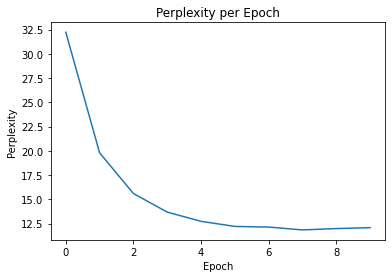

In [24]:
plot_perplexity(dev_perplexities)

## Prediction and Evaluation

Once trained we can use the model to produce a set of translations. 

If we translate the whole validation set, we can use [SacreBLEU](https://github.com/mjpost/sacreBLEU) to get a [BLEU score](https://en.wikipedia.org/wiki/BLEU), which is the most common way to evaluate translations.

#### Important sidenote
Typically you would use SacreBLEU from the **command line** using the output file and original (possibly tokenized) development reference file. This will give you a nice version string that shows how the BLEU score was calculated; for example, if it was lowercased, if it was tokenized (and how), and what smoothing was used. If you want to learn more about how BLEU scores are (and should be) reported, check out [this paper](https://arxiv.org/abs/1804.08771).

However, right now our pre-processed data is only in memory, so we'll calculate the BLEU score right from this notebook for demonstration purposes.

We'll first test the raw BLEU function:

In [27]:
import sacrebleu

In [28]:
# this should result in a perfect BLEU of 100%
hypotheses = ["this is a test"]
references = ["this is a test"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

100.00000000000004


In [ ]:
# here the BLEU score will be lower, because some n-grams won't match
hypotheses = ["this is a test"]
references = ["this is a fest"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

Since we did some filtering for speed, our validation set contains 690 sentences.
The references are the tokenized versions, but they should not contain out-of-vocabulary UNKs that our network might have seen. So we'll take the references straight out of the `valid_data` object:

In [29]:
len(valid_data)

690

In [30]:
references = [" ".join(example.trg) for example in valid_data]
print(len(references))
print(references[0])

690
when i was 11 , i remember waking up one morning to the sound of joy in my house .


In [31]:
references[-2]

"i 'm always the one taking the picture ."

**Now we translate the validation set!**

This might take a little bit of time.

Note that `greedy_decode` will cut-off the sentence when it encounters the end-of-sequence symbol, if we provide it the index of that symbol.

In [32]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [33]:
# we will still need to convert the indices to actual words!
hypotheses[0]

array([  70,   11,   24, 1460,  103,  217,    5,   11,   24,    9,    0,
         10,    6,    0,  334,  937,    0,    4])

In [34]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

['when',
 'i',
 'was',
 '11',
 'years',
 'old',
 ',',
 'i',
 'was',
 'a',
 '<unk>',
 'of',
 'the',
 '<unk>',
 'guy',
 'named',
 '<unk>',
 '.']

In [35]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

690
when i was 11 years old , i was a <unk> of the <unk> guy named <unk> .


In [36]:
# now we can compute the BLEU score!
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

23.435618533528125


## Attention Visualization

We can also visualize the attention scores of the decoder.

In [37]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

src ['"', 'jetzt', 'kannst', 'du', 'auf', 'eine', 'richtige', 'schule', 'gehen', ',', '"', 'sagte', 'er', '.', '</s>']
ref ['"', 'you', 'can', 'go', 'to', 'a', 'real', 'school', 'now', ',', '"', 'he', 'said', '.', '</s>']
pred ['"', 'now', 'you', 'can', 'go', 'to', 'a', 'right', 'exam', ',', '"', 'he', 'said', '.', '</s>']


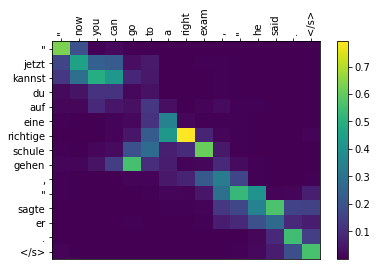

In [38]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

# Congratulations! You've finished this notebook.

What didn't we cover?

- Subwords / Byte Pair Encoding [[paper]](https://arxiv.org/abs/1508.07909) [[github]](https://github.com/rsennrich/subword-nmt) let you deal with unknown words. 
- You can implement a [multiplicative/bilinear attention mechanism](https://arxiv.org/abs/1508.04025) instead of the additive one used here.
- We used greedy decoding here to get translations, but you can get better results with beam search.
- The original model only uses a single dropout layer (in the decoder), but you can experiment with adding more dropout layers, for example on the word embeddings and the source word representations.
- You can experiment with multiple encoder/decoder layers.- Experiment with a benchmarked and improved codebase: [Joey NMT](https://github.com/joeynmt/joeynmt)

If this was useful to your research, please consider citing:

> J Bastings. 2018. The Annotated Encoder-Decoder with Attention. https://bastings.github.io/annotated_encoder_decoder/

Or use the following `Bibtex`:
```
@misc{bastings2018annotated,
  title={The Annotated Encoder-Decoder with Attention},
  author={Bastings, J.},
  journal={https://bastings.github.io/annotated\_encoder\_decoder/},
  year={2018}
}```